In [1]:
from utils import top_anomalous, top_mean_anomalous, errorbar_classification
from util import _calc_grid_size, tile_tv_images

from verification_net import VerificationNet
from model_trainer import ModelTrainer
from autoencoder import AutoEncoder

from stacked_mnist import StackedMNIST, DataMode

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple

In [3]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

trainer_file = Path("trainers/ae-basic.pkl")
model_file = Path("models/ae-basic")

In [4]:
class StackedAE(AutoEncoder):
    def __init__(self, latent_space_size: int = 64) -> None:
        super().__init__(latent_space_size)
        self.latent_space_size = latent_space_size
        
    def forward(self, x):
        nb_channels = x.shape[1]
        x_hats = []
        z_hats = []
        for channel in range(nb_channels):
            z_hat = self.encoder(x[:, [channel], :, :]).view(-1,1,self.latent_space_size)
            x_hat = self.decoder(z_hat.view(-1,self.latent_space_size))
            z_hats.append(z_hat)
            x_hats.append(x_hat)

        z_hats = torch.cat(z_hats, dim=1)
        x_hats = torch.cat(x_hats, dim=1)
        return z_hats, x_hats


In [5]:
class AutoEncoderTrainer(ModelTrainer):
    def __init__(
            self, 
            model, 
            loss, 
            optimizer,
            device = torch.device("mps"),
            file_name: str | Path = model_file, 
            force_learn: bool = False
        ) -> None:
        super().__init__(model, loss, optimizer, device, file_name, force_learn)

    def get_output_from_batch(self, batch):
        x, _, _ = batch
        x = x.to(self.device)
        _, output = self.model(x)
        return x, output

In [6]:
latent_space_size = 64
mode = DataMode.COLOR
trainset = StackedMNIST(train=True, mode=mode)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
loss = nn.MSELoss()

In [8]:
AE = StackedAE(latent_space_size=latent_space_size)
Trainer = ModelTrainer(
    model=AE,
    loss = loss,
    optimizer=None,
    file_name=model_file,
    force_learn=False
)
# Trainer = Trainer.load_trainer(trainer_file)
VerifNet = VerificationNet(file_name='models/verification_model_torch_ok_copy')

In [9]:
def print_reconstructed_img(dataset, batch_size: int = 25, print_original_image: bool = False):
    data = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    imgs, _, labels = next(iter(data))
    _, imgs_pred = AE(imgs.to(device))
    labels = labels.detach().numpy()
    imgs_pred = imgs_pred.permute(0, 2, 3, 1).to("cpu").detach().numpy()

    tile_tv_images(images=imgs_pred, labels=labels)

# Show STACK basic

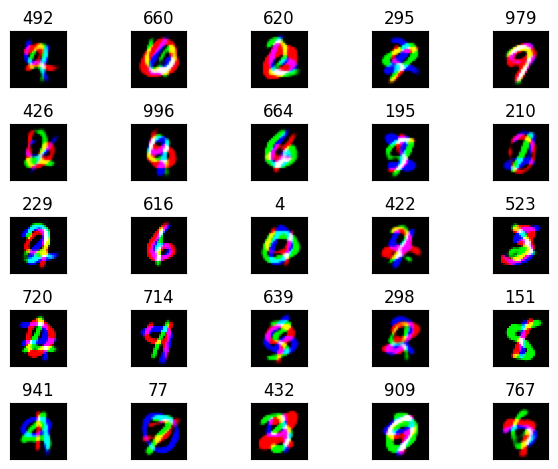

In [10]:
Trainer.print_reconstructed_img(testset, batch_size=25)

In [11]:
# print_reconstructed_img(testset)

# Show STACK GEN

In [12]:
batch_size = 10_000
z_noise = nn.Softmax(dim=2)(torch.rand(batch_size, 3, latent_space_size)).to(device)

x_hats = []
for channel in range(3):
    x_hat = AE.decoder(z_noise[:,[channel],:].view(-1, latent_space_size))
    x_hats.append(x_hat)

img_gens = torch.cat(x_hats, dim=1)

In [13]:
cov = VerifNet.check_class_coverage(data=img_gens, tolerance=.5)
pred, acc = VerifNet.check_predictability(data=img_gens, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 49.10%
Predictability: 94.81%


In [14]:
noise_labels, beliefs = VerifNet.predict(img_gens)

(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: title={'center': '338'}>, <Axes: title={'center': '333'}>,
         <Axes: title={'center': '388'}>, <Axes: title={'center': '437'}>],
        [<Axes: title={'center': '835'}>, <Axes: title={'center': '338'}>,
         <Axes: title={'center': '337'}>, <Axes: title={'center': '353'}>],
        [<Axes: title={'center': '333'}>, <Axes: title={'center': '333'}>,
         <Axes: title={'center': '333'}>, <Axes: title={'center': '333'}>],
        [<Axes: title={'center': '333'}>, <Axes: title={'center': '338'}>,
         <Axes: title={'center': '333'}>, <Axes: title={'center': '333'}>]],
       dtype=object))

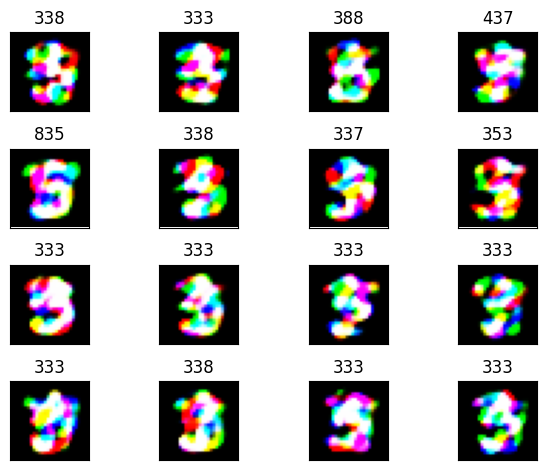

In [15]:
arg_beliefs = np.flip(np.argsort(beliefs))[:16]
imgs_gen_to_plot = img_gens.permute(0, 2, 3, 1).to("cpu").detach().numpy()[arg_beliefs]

tile_tv_images(images=imgs_gen_to_plot, labels=noise_labels[arg_beliefs].astype(np.intc))

# Show STACK MISSING

In [16]:
latent_space_size = 64
mode = DataMode.COLOR
trainset = StackedMNIST(train=True, mode=mode | DataMode.MISSING)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [20]:
AE = StackedAE(latent_space_size=latent_space_size)
Trainer = ModelTrainer(
    model=AE,
    loss = None,
    optimizer=None,
    file_name="models/ae-anom",
    force_learn=False
)

In [21]:
train_set = DataLoader(trainset, shuffle=True, batch_size=2048)
test_set = DataLoader(testset, shuffle=True, batch_size=2048)

In [22]:
Trainer.print_class_coverage_and_predictability(VerifNet, trainset)

Coverage: 74.00%
Predictability: 98.11%
Accuracy: 92.97%


In [23]:
Trainer.print_class_coverage_and_predictability(VerifNet, testset)

Coverage: 99.90%
Predictability: 96.69%
Accuracy: 87.90%


In [25]:
data = DataLoader(trainset, shuffle=True, batch_size=10000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
_, preds = AE(imgs.to(device))

In [26]:
labels_hat, beliefs = VerifNet.predict(imgs)

In [27]:
idx = np.argwhere(labels_hat==8)

In [30]:
def calculate_class_accuracies(X, X_hat, labels):
    class_accuracies = [[] for _ in range(10)]

    for x, x_hat, label in zip(X, X_hat, labels):
        class_accuracies[label].append(loss(x, x_hat))

    mean_accuracy = [np.mean(acc) for acc in class_accuracies]
    std_accuracy = [np.std(acc) for acc in class_accuracies]

    return mean_accuracy, std_accuracy

In [32]:
data = DataLoader(testset, shuffle=True, batch_size=10_000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
_, preds = AE(imgs.to(device))

In [33]:
X = imgs.to(device)
X_hat = preds.to(device)

In [34]:
class_accuracies = [[] for _ in range(1000)]
losses = []
for x, x_hat, label in zip(X, X_hat, labels):
    class_accuracies[label].append(loss(x, x_hat).item())
    losses.append(loss(x, x_hat).item())
    
mean_accuracy = [np.mean(acc) for acc in class_accuracies]
std_accuracy = [np.std(acc) for acc in class_accuracies]
losses = np.array(losses)

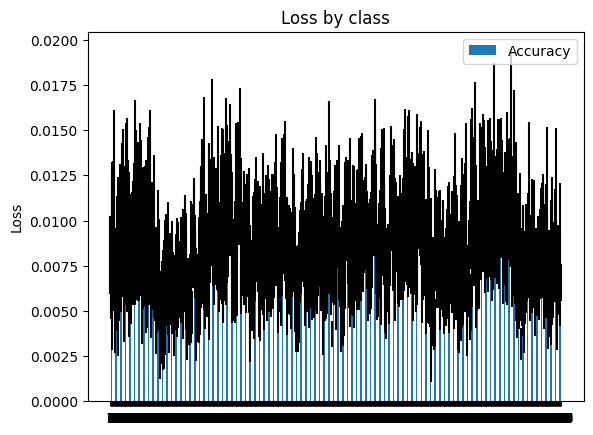

In [35]:
errorbar_classification(np.arange(1000), mean_accuracy=mean_accuracy, std_accuracy=std_accuracy)

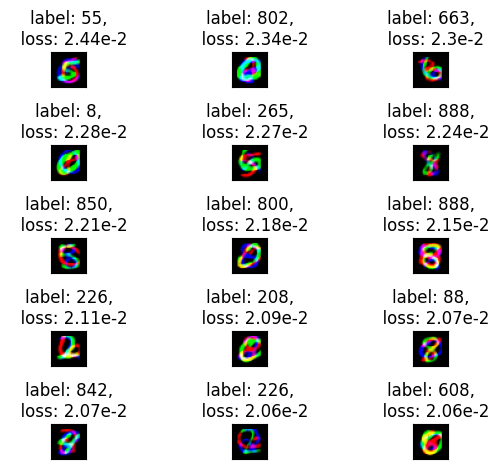

In [37]:
top_anomalous(15, losses, preds.permute(0, 2, 3, 1).to("cpu").detach().numpy(), labels)

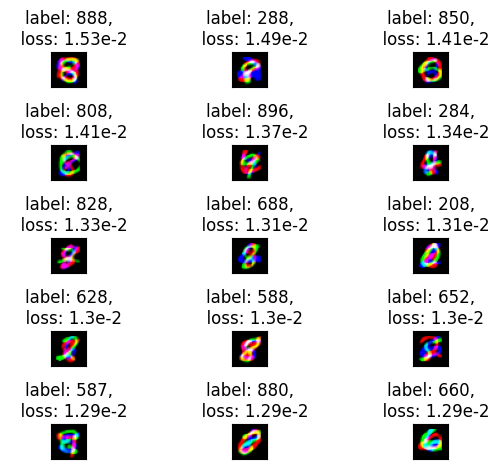

In [39]:
top_mean_anomalous(15, mean_accuracy, preds, labels)
